In [2]:
from typing import Dict, List, Tuple, Union

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import empyrical as ep
# from data_service import (get_interpld_shibor, get_shibor_data, prepare_data,
#                           query_china_shibor_all)
# from jqdata import *

from scr.calc_func import (CVIX, prepare_data2calc,get_n_next_ret,get_quantreg_res)
from scr.plotting import (plot_group_ret, plot_hist2d, plot_indicator,
                          plot_quantreg_res,plot_qunatile_signal)

# 设置字体 用来正常显示中文标签
mpl.rcParams['font.sans-serif'] = ['SimHei']
#mpl.rcParams['font.family'] = 'serif'
# 用来正常显示负号
mpl.rcParams['axes.unicode_minus'] = False


本篇算法来源：
>《20180707_东北证券_金融工程_市场波动风险度量：vix与skew指数构建与应用》

In [ ]:
# 数据获取
start,end = '2015-02-09','2022-05-27'
opt_data = prepare_data('510050.XSHG', start, end)
shibor_df = get_shibor_data(start, end)

# 插值
interpld_shibor = get_interpld_shibor(shibor_df)

In [ ]:
# 数据储存
opt_data.to_csv(r'../Data/opt_data.csv')
interpld_shibor.to_csv(r'../Data/interpld_shibor.csv')

In [3]:
# 数据读取
opt_data:pd.DataFrame = pd.read_csv(r'Data/opt_data.csv',
                       index_col=[0], parse_dates=['date'])

interpld_shibor:pd.DataFrame = pd.read_csv(
    r'Data/interpld_shibor.csv', index_col=[0], parse_dates=True)

interpld_shibor.columns = list(map(int,interpld_shibor.columns))
# 读取数据
sz50:pd.DataFrame = pd.read_csv(r'Data/sz50.csv',parse_dates=True,index_col=[0])
hs300:pd.DataFrame = pd.read_csv(r'Data/hs300.csv',parse_dates=True,index_col=[0])

In [4]:
# 前期数据整理
data_all = prepare_data2calc(opt_data,interpld_shibor)

In [5]:
# 加载模块
vix_func = CVIX(data_all)

In [6]:
# 计算vix
vix:pd.Series = vix_func.vix()

# 计算skew
skew:pd.Series = vix_func.skew()

e:\WorkSpace\Quantitative-analysis\C-择时类\C-VIX中国版VIX编制手册\scr\calc_func.py:171: UserWarning: F:2.7309,strike_marix中最小执行价为:2.7500,故开跌部分无数据,无中间价K0.
  warnings.warn('F:%.4f,strike_marix中最小执行价为:%.4f,故开跌部分无数据,无中间价K0.' %
e:\WorkSpace\Quantitative-analysis\C-择时类\C-VIX中国版VIX编制手册\scr\calc_func.py:171: UserWarning: F:2.7550,strike_marix中最小执行价为:2.8000,故开跌部分无数据,无中间价K0.
  warnings.warn('F:%.4f,strike_marix中最小执行价为:%.4f,故开跌部分无数据,无中间价K0.' %
e:\WorkSpace\Quantitative-analysis\C-择时类\C-VIX中国版VIX编制手册\scr\calc_func.py:171: UserWarning: F:2.4662,strike_marix中最小执行价为:2.5000,故开跌部分无数据,无中间价K0.
  warnings.warn('F:%.4f,strike_marix中最小执行价为:%.4f,故开跌部分无数据,无中间价K0.' %
e:\WorkSpace\Quantitative-analysis\C-择时类\C-VIX中国版VIX编制手册\scr\calc_func.py:171: UserWarning: F:2.4619,strike_marix中最小执行价为:2.5000,故开跌部分无数据,无中间价K0.
  warnings.warn('F:%.4f,strike_marix中最小执行价为:%.4f,故开跌部分无数据,无中间价K0.' %
e:\WorkSpace\Quantitative-analysis\C-择时类\C-VIX中国版VIX编制手册\scr\calc_func.py:171: UserWarning: F:2.3890,strike_marix中最小执行价为:2.4000,故开跌部分无数据,无中间价K0.

## VIX、STEW与上证50的关系

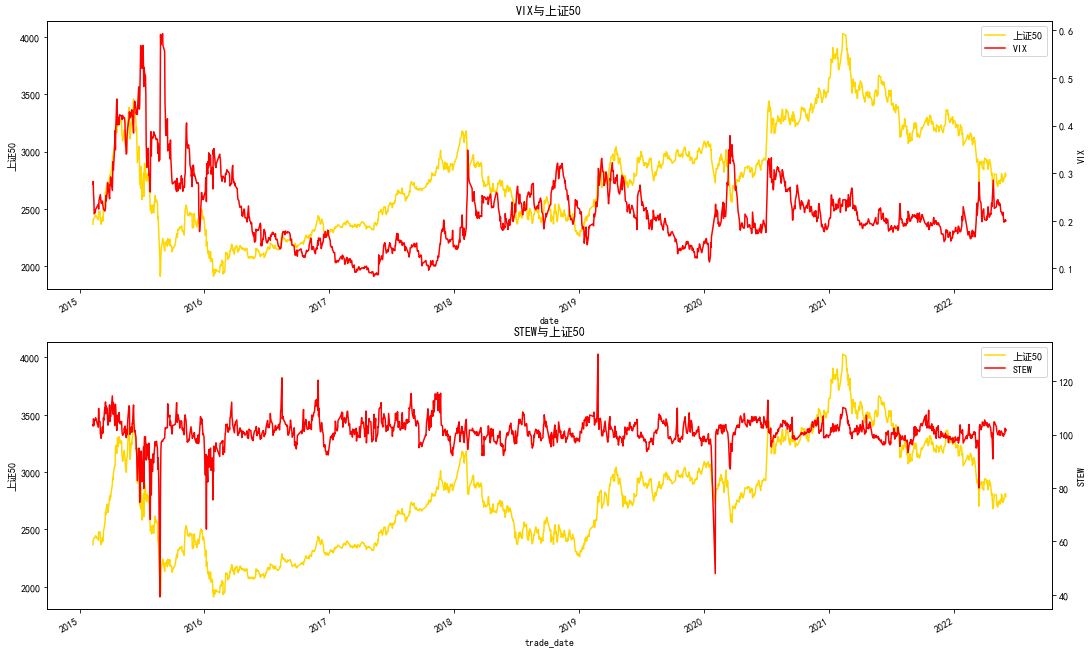

In [7]:
fig, axes = plt.subplots(2, figsize=(18, 12), sharex=False)

plot_indicator(sz50['close'],
               vix, ['上证50', 'VIX'], ['上证50', 'VIX'],
               'VIX与上证50',
               ax=axes[0])

plot_indicator(sz50['close'],
               skew, ['上证50', 'STEW'], ['上证50', 'STEW'],
               'STEW与上证50',
               ax=axes[1]);

## VIX、STEW与沪深300的关系

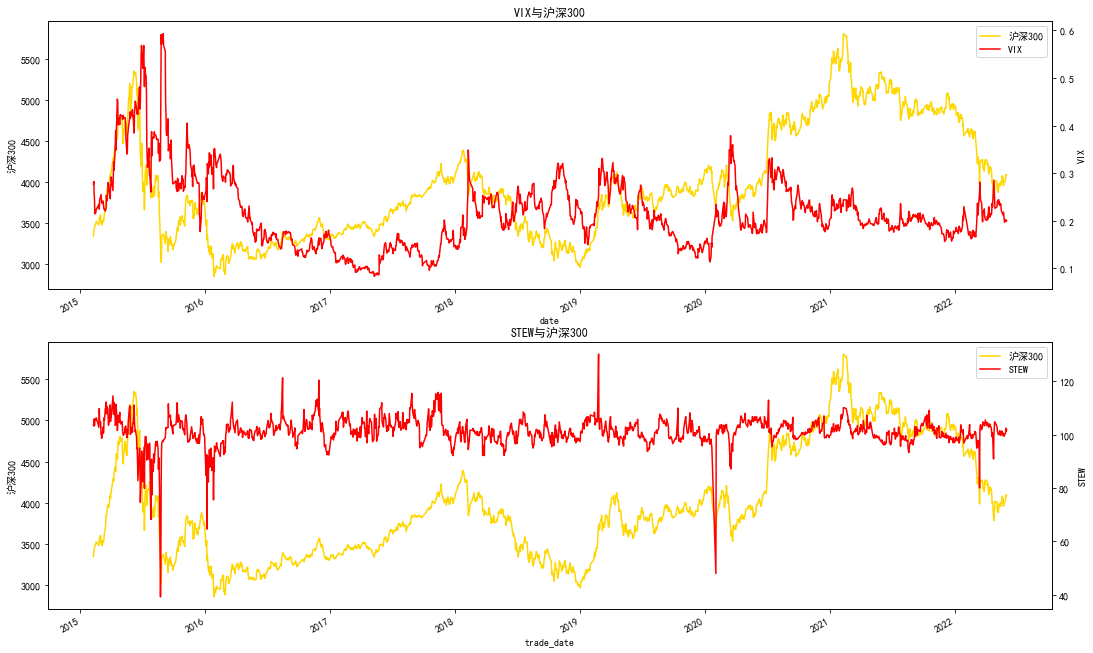

In [8]:
fig, axes = plt.subplots(2, figsize=(18, 12), sharex=False)

plot_indicator(hs300['close'],
               vix, ['沪深300', 'VIX'], ['沪深300', 'VIX'],
               'VIX与沪深300',
               ax=axes[0])

plot_indicator(hs300['close'],
               skew, ['沪深300', 'STEW'], ['沪深300', 'STEW'],
               'STEW与沪深300',
               ax=axes[1]);

## 信号与指数收益的关系

**上证50**

可以看到VIX信号在低分位对应的未来N期收益率均值都有较好的表现;高分位有较明显的拥挤效应出现,对应的是较明显的负向收益。

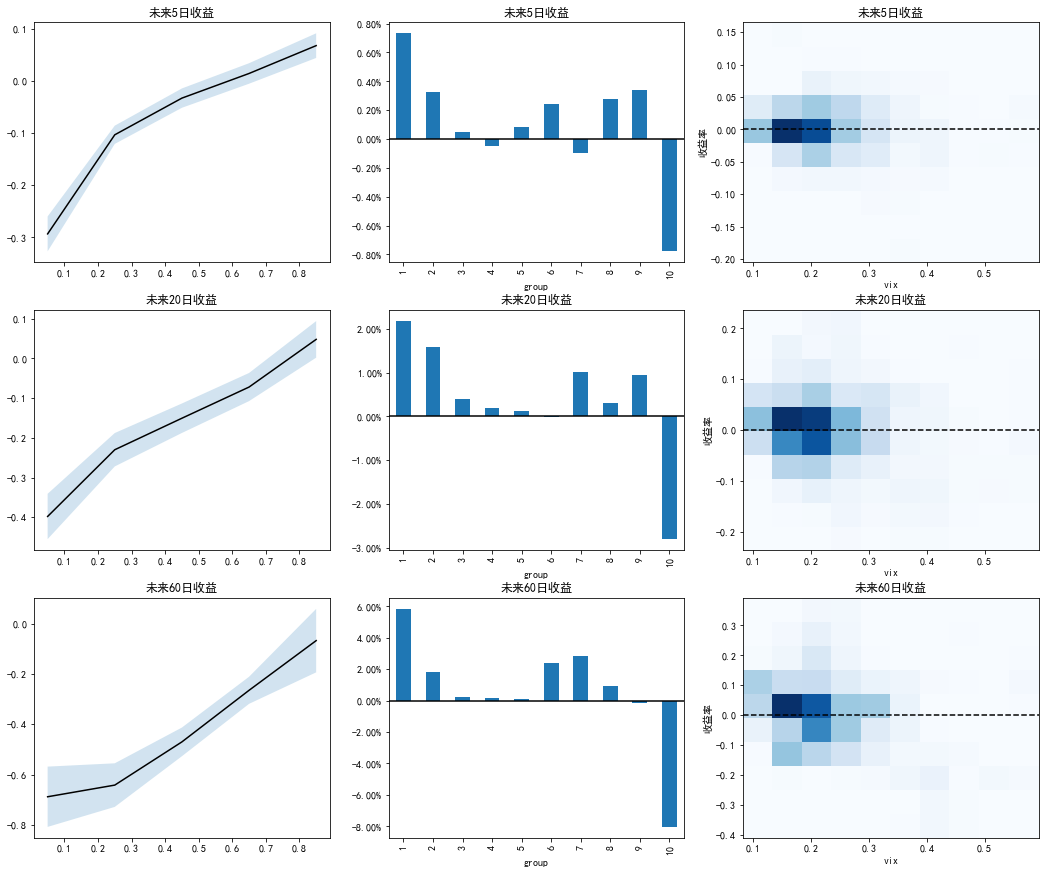

In [9]:
# 上证50与vix的关系

## 对齐未来收益与vix
algin_next_chg, algin_vix = get_n_next_ret(sz50['close'],vix)

## 获取模型结果 
models_dic: Dict = {
    name: get_quantreg_res(ser, algin_vix)
    for name,ser in algin_next_chg.items()
}
    
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

## 画图
for (k, v), ax in zip(models_dic.items(), axes):

    plot_quantreg_res(v, title=k, ax=ax[0])
    plot_group_ret(algin_vix, algin_next_chg[k], title=k, ax=ax[1])
    plot_hist2d(algin_vix, algin_next_chg[k], title=k, ax=ax[2])

**沪深300**

可以看到VIX信号在低分位对应的未来N期收益率均值都有较好的表现;高分位有较明显的拥挤效应出现,对应的是较明显的负向收益。

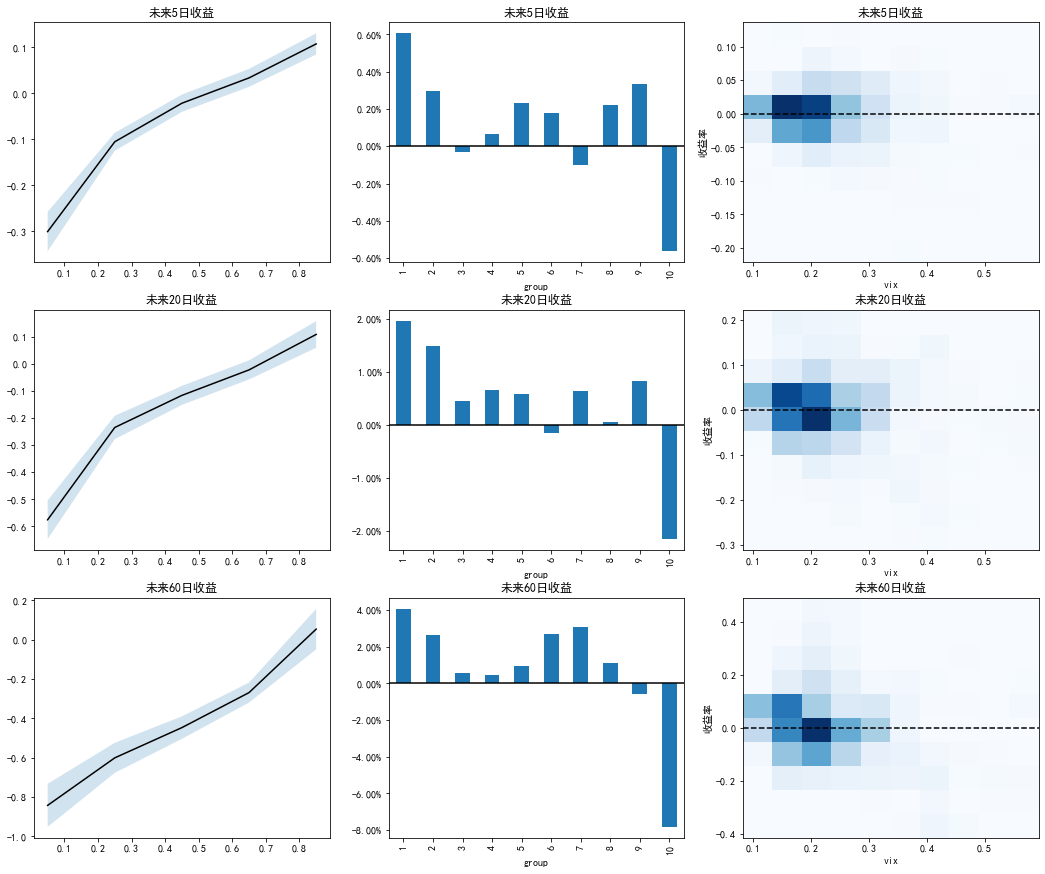

In [10]:
# 沪深300与vix的关系

## 对齐未来收益与vix
algin_next_chg, algin_vix = get_n_next_ret(hs300['close'],vix)

## 获取模型结果 
models_dic: Dict = {
    name: get_quantreg_res(ser, algin_vix)
    for name,ser in algin_next_chg.items()
}
    
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

## 画图
for (k, v), ax in zip(models_dic.items(), axes):

    plot_quantreg_res(v, title=k, ax=ax[0])
    plot_group_ret(algin_vix, algin_next_chg[k], title=k, ax=ax[1])
    plot_hist2d(algin_vix, algin_next_chg[k], title=k, ax=ax[2])

### 根据收益与VIX关系构造上下轨

**上证50**

由上可知在VIX低于20%分为数有较高的上涨概率,故根据上面的结论构建信号

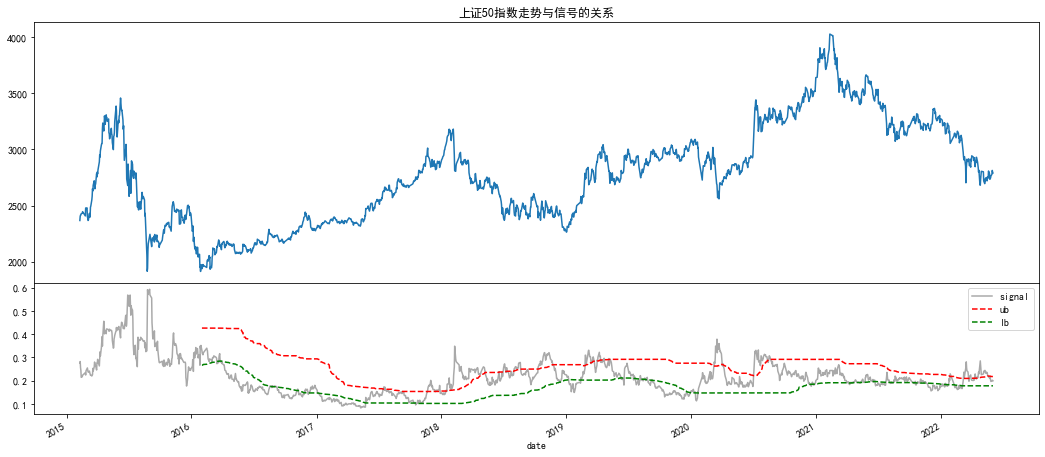

In [11]:
plot_qunatile_signal(sz50['close'],vix,240,(85,20),'上证50指数走势与信号的关系');

**沪深300**

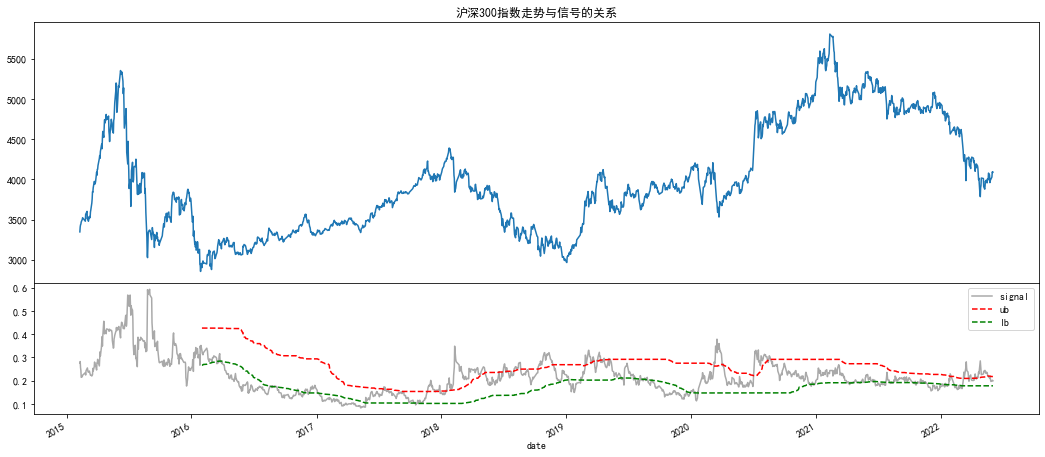

In [12]:
plot_qunatile_signal(hs300['close'],vix,240,(85,20),'沪深300指数走势与信号的关系');

In [ ]:
import backtrader as bt